In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from invest.resample import resample_returns
from invest.calculation import calculate_cumulative_value_with_contributions_and_rebalancing

In [3]:
# Define the constants for the analysis
START_DATE = "2016-08-01"
END_DATE = "2024-08-01"
INVESTMENT_PERIOD = 90  # invest every 30 days
TICKERS = [
    "AAPL",
    "NVDA",
    "MSFT",
    "AMZN",
    "SPY",
    "GOOG",
]
MONTLY_INVESTMENT = 1000  # Define initial investment amount

[*********************100%%**********************]  6 of 6 completed


Optimized Portfolio Weights:
OrderedDict({'AAPL': 0.28217, 'AMZN': 0.1, 'GOOG': 0.1, 'MSFT': 0.11783, 'NVDA': 0.3, 'SPY': 0.1})
Expected annual return: 40.5%
Annual volatility: 29.5%
Sharpe Ratio: 1.31


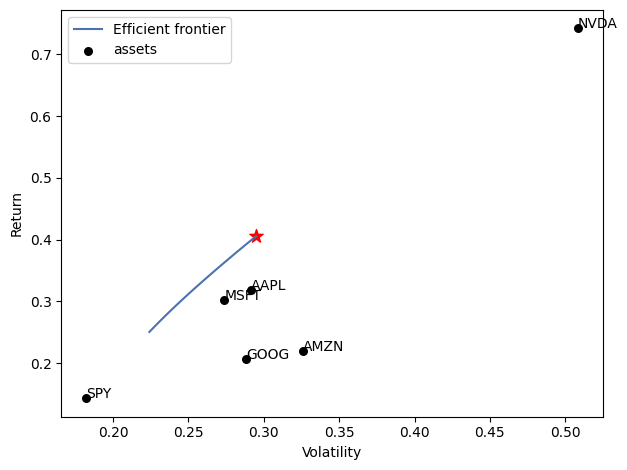

In [4]:
# Step 1: Download historical price data

data = yf.download(TICKERS, start=START_DATE, end=END_DATE)["Adj Close"]

# Step 2: Calculate daily returns
returns = data.pct_change().dropna()

# Step 3: Calculate the expected annual return and the annual sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Step 4: Optimize for maximum Sharpe ratio
# Define the minimum and maximum weights for each asset
weight_bounds = {
    "AAPL": (0.1, 0.3),
    "NVDA": (0.1, 0.3),
    "MSFT": (0.1, 0.3),
    "AMZN": (0.1, 0.3),
    "SPY": (0.1, 0.5),
    "GOOG": (0.1, 0.5),
}

# Convert the bounds dictionary to a list of tuples in the order of the tickers
bounds = [weight_bounds[ticker] for ticker in mu.index]

# Initialize EfficientFrontier with weight bounds
ef = EfficientFrontier(mu, S, weight_bounds=bounds)
weights = ef.max_sharpe()

# Step 5: Clean the weights and display
cleaned_weights = ef.clean_weights()
print("Optimized Portfolio Weights:")
print(cleaned_weights)

# Step 6: Display the expected annual return, annual volatility, and Sharpe ratio of the optimized portfolio
ef.portfolio_performance(verbose=True)

fig, ax = plt.subplots()
ef = EfficientFrontier(mu, S, weight_bounds=bounds)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, show_tickers=True)

# Find the tangency portfolio
ef = EfficientFrontier(mu, S, weight_bounds=bounds)
ef.max_sharpe()

ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
plt.show()

[*********************100%%**********************]  6 of 6 completed


Optimized Portfolio Weights:
OrderedDict({'AAPL': 0.18333, 'AMZN': 0.15, 'GOOG': 0.15, 'MSFT': 0.18333, 'NVDA': 0.18333, 'SPY': 0.15})
Expected annual return: 33.5%
Annual volatility: 26.6%
Sharpe Ratio: 1.18


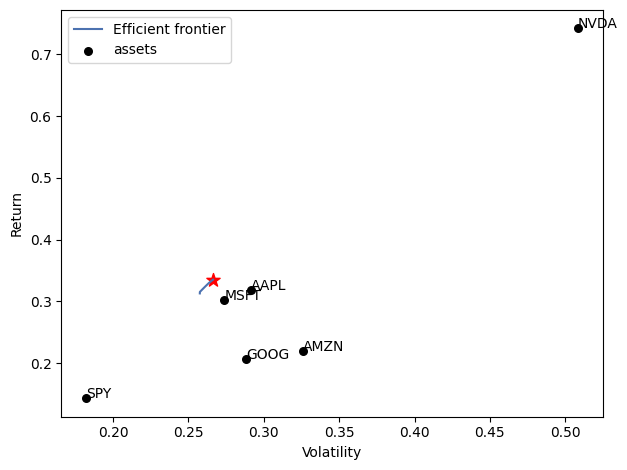

In [5]:
# Step 1: Download historical price data

data = yf.download(TICKERS, start=START_DATE, end=END_DATE)["Adj Close"]

# Step 2: Calculate daily returns
returns = data.pct_change().dropna()

# Step 3: Calculate the expected annual return and the annual sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Step 4: Optimize for maximum Sharpe ratio
# Define the minimum and maximum weights for each asset
weight_bounds = {
    t: (
        1 / len(TICKERS) - 0.1 / len(TICKERS),
        1 / len(TICKERS) + 0.1 / len(TICKERS),
    )
    for t in TICKERS
}

# Convert the bounds dictionary to a list of tuples in the order of the tickers
bounds = [weight_bounds[ticker] for ticker in mu.index]

# Initialize EfficientFrontier with weight bounds
ef = EfficientFrontier(mu, S, weight_bounds=bounds)
weights = ef.max_sharpe()

# Step 5: Clean the weights and display
cleaned_weights = ef.clean_weights()
print("Optimized Portfolio Weights:")
print(cleaned_weights)

# Step 6: Display the expected annual return, annual volatility, and Sharpe ratio of the optimized portfolio
ef.portfolio_performance(verbose=True)

fig, ax = plt.subplots()
ef = EfficientFrontier(mu, S, weight_bounds=bounds)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, show_tickers=True)

# Find the tangency portfolio
ef = EfficientFrontier(mu, S, weight_bounds=bounds)
ef.max_sharpe()

ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
plt.show()

In [6]:
# Ensure cleaned_weights is a pandas Series and aligns with the returns DataFrame columns
cleaned_weights = pd.Series(cleaned_weights).reindex(returns.columns).fillna(0)

# Step 6: Calculate the weighted portfolio returns over time
portfolio_returns = returns.dot(cleaned_weights)

/var/folders/cj/svt_xhpj7vz3m8hbddg45szc0000gn/T/ipykernel_40252/2037968005.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_portfolio_value = cumulative_value[-1]
/var/folders/cj/svt_xhpj7vz3m8hbddg45szc0000gn/T/ipykernel_40252/2037968005.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_investment = total_invested[-1]


Final portfolio value at end date: $383981.02
Total amount invested: $96000.00
Total return percentage: 299.98%


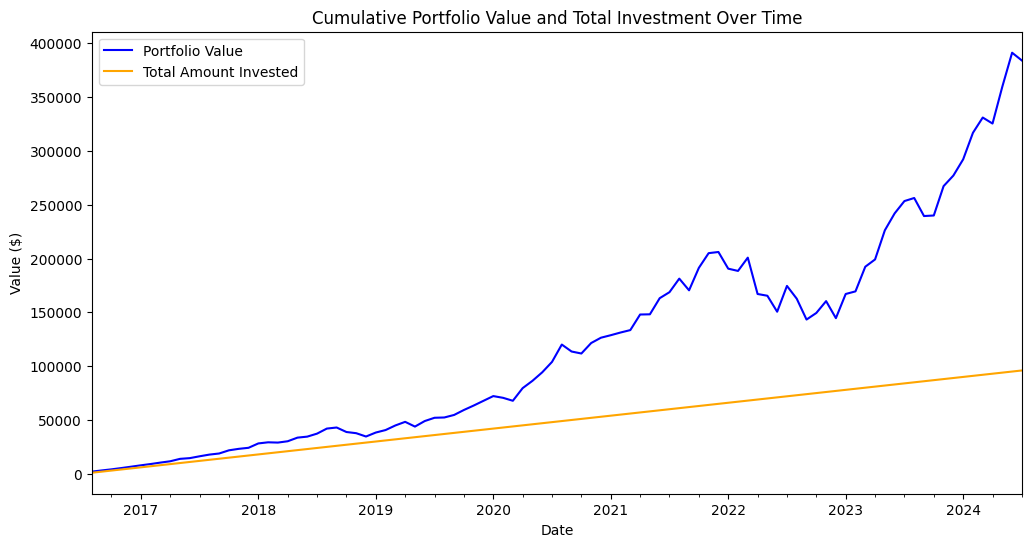

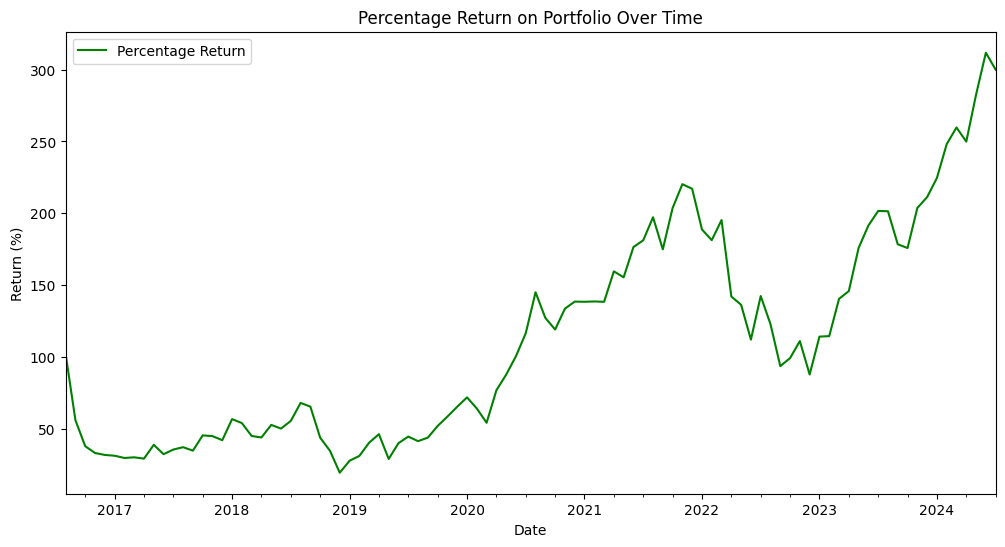

In [7]:
FREQUENCY = "monthly"
REBALANCE_FREQUENCY = "yearly"

portfolio_returns_resampled = resample_returns(portfolio_returns, FREQUENCY)
initial_weights = pd.Series(cleaned_weights).reindex(returns.columns).fillna(0)

investment_amount = 1000  # Monthly investment amount
cumulative_value, total_invested = (
    calculate_cumulative_value_with_contributions_and_rebalancing(
        portfolio_returns,
        initial_weights,
        investment_amount,
        FREQUENCY,
        REBALANCE_FREQUENCY,
    )
)

# Final portfolio value at the end date
final_portfolio_value = cumulative_value[-1]
print(f"Final portfolio value at end date: ${final_portfolio_value:.2f}")

# Calculate total investment and % return
total_investment = total_invested[-1]
percent_return = ((final_portfolio_value - total_investment) / total_investment) * 100
print(f"Total amount invested: ${total_investment:.2f}")
print(f"Total return percentage: {percent_return:.2f}%")

# Convert lists to Series for plotting
cumulative_value_series = pd.Series(
    cumulative_value, index=portfolio_returns_resampled.index
)
total_invested_series = pd.Series(
    total_invested, index=portfolio_returns_resampled.index
)

# Plot cumulative portfolio value over time
plt.figure(figsize=(12, 6))
cumulative_value_series.plot(label="Portfolio Value", color="blue")
total_invested_series.plot(label="Total Amount Invested", color="orange")
plt.title("Cumulative Portfolio Value and Total Investment Over Time")
plt.ylabel("Value ($)")
plt.xlabel("Date")
plt.legend()
plt.show()

# Plot the percentage return over time
percentage_returns_series = (
    (cumulative_value_series - total_invested_series) / total_invested_series
) * 100
plt.figure(figsize=(12, 6))
percentage_returns_series.plot(label="Percentage Return", color="green")
plt.title("Percentage Return on Portfolio Over Time")
plt.ylabel("Return (%)")
plt.xlabel("Date")
plt.legend()
plt.show()